# Colab E(ii): TensorFlow with Built-in Keras Layers (Model Subclassing)

**Using `tf.keras.layers.Dense`, `tf.keras.Model` subclassing, and custom `GradientTape` loop**

---

### Approach
- `tf.keras.Model` subclass defines the architecture
- `tf.keras.layers.Dense` provides built-in layer functionality
- Custom training loop via `tf.GradientTape` (NOT `model.fit`)

## Cell 1: Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

tf.random.set_seed(42)
np.random.seed(42)
print(f'TensorFlow: {tf.__version__}')

TensorFlow: 2.19.0


## Cell 2: Generate & Prepare Data

In [2]:
num_samples = 2000
x1 = np.random.uniform(-2, 2, num_samples)
x2 = np.random.uniform(-2, 2, num_samples)
x3 = np.random.uniform(-2, 2, num_samples)
y_true = np.sin(x1) * x2**2 + np.cos(x3) * x1 + 0.5 * x3 * x2

X_np = np.column_stack([x1, x2, x3]).astype(np.float32)
Y_np = y_true.reshape(-1, 1).astype(np.float32)
X_mean, X_std = X_np.mean(0), X_np.std(0)
Y_mean, Y_std = Y_np.mean(), Y_np.std()
X_norm = ((X_np - X_mean) / X_std).astype(np.float32)
Y_norm = ((Y_np - Y_mean) / Y_std).astype(np.float32)

split = int(0.8 * num_samples)
train_ds = tf.data.Dataset.from_tensor_slices((X_norm[:split], Y_norm[:split])).shuffle(2000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((X_norm[split:], Y_norm[split:])).batch(64)
print(f'Train: {split}, Test: {num_samples - split}')

Train: 1600, Test: 400


## Cell 3: 4D Visualization

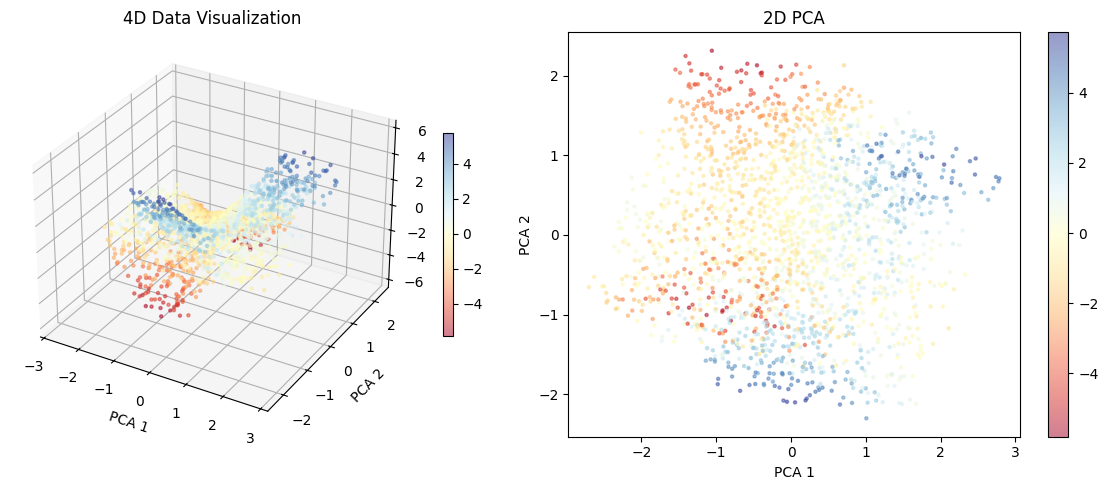

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], Y_np.flatten(), c=Y_np.flatten(), cmap='RdYlBu', s=5, alpha=0.5)
ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('y')
ax.set_title('4D Data Visualization')
plt.colorbar(sc, ax=ax, shrink=0.5)
ax2 = fig.add_subplot(122)
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_np.flatten(), cmap='RdYlBu', s=5, alpha=0.5)
ax2.set_xlabel('PCA 1'); ax2.set_ylabel('PCA 2'); ax2.set_title('2D PCA')
plt.colorbar(sc2, ax=ax2)
plt.tight_layout(); plt.show()

## Cell 4: Model Subclassing with Built-in Dense Layers

In [4]:
class RegressionDNN(keras.Model):
    """3-Layer DNN using Keras Model subclassing with built-in Dense layers."""

    def __init__(self):
        super(RegressionDNN, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='hidden_1')
        self.dense2 = layers.Dense(32, activation='relu', kernel_initializer='he_normal', name='hidden_2')
        self.dense3 = layers.Dense(16, activation='relu', kernel_initializer='he_normal', name='hidden_3')
        self.out = layers.Dense(1, name='output')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.out(x)

model = RegressionDNN()
model.build(input_shape=(None, 3))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'regression_dnn', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "regression_dnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Cell 5: Optimizer, Loss & Custom Training Loop

In [5]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.MeanSquaredError()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        preds = model(x, training=True)
        loss = loss_fn(y, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def test_step(x, y):
    preds = model(x, training=False)
    return loss_fn(y, preds)

print('Training functions compiled with @tf.function')

Training functions compiled with @tf.function


## Cell 6: Training

In [6]:
epochs = 50
train_losses, test_losses = [], []

for epoch in range(epochs):
    t_loss, t_n = 0.0, 0
    for xb, yb in train_ds:
        t_loss += train_step(xb, yb).numpy()
        t_n += 1
    v_loss, v_n = 0.0, 0
    for xb, yb in test_ds:
        v_loss += test_step(xb, yb).numpy()
        v_n += 1
    train_losses.append(t_loss / t_n)
    test_losses.append(v_loss / v_n)
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f'Epoch {epoch+1:>3}/{epochs} | Train: {train_losses[-1]:.6f} | Test: {test_losses[-1]:.6f}')

print(f'\nFinal Train: {train_losses[-1]:.6f}, Test: {test_losses[-1]:.6f}')

Epoch   1/50 | Train: 1.210447 | Test: 0.310024
Epoch  20/50 | Train: 0.021455 | Test: 0.023251
Epoch  40/50 | Train: 0.014623 | Test: 0.016636

Final Train: 0.010521, Test: 0.012644


## Cell 7: Loss Curves

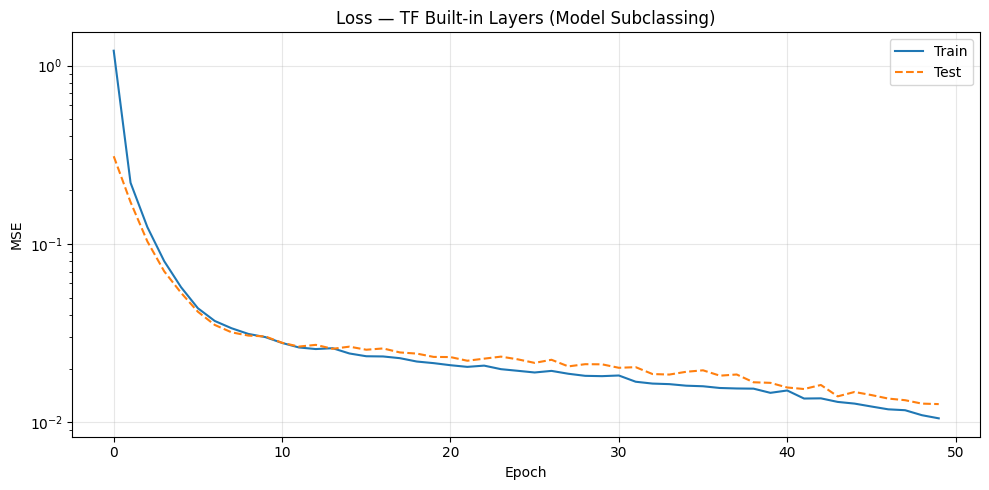

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train', lw=1.5)
plt.plot(test_losses, label='Test', lw=1.5, ls='--')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.title('Loss — TF Built-in Layers (Model Subclassing)')
plt.legend(); plt.grid(True, alpha=0.3); plt.yscale('log')
plt.tight_layout(); plt.show()

## Cell 8: Final Results

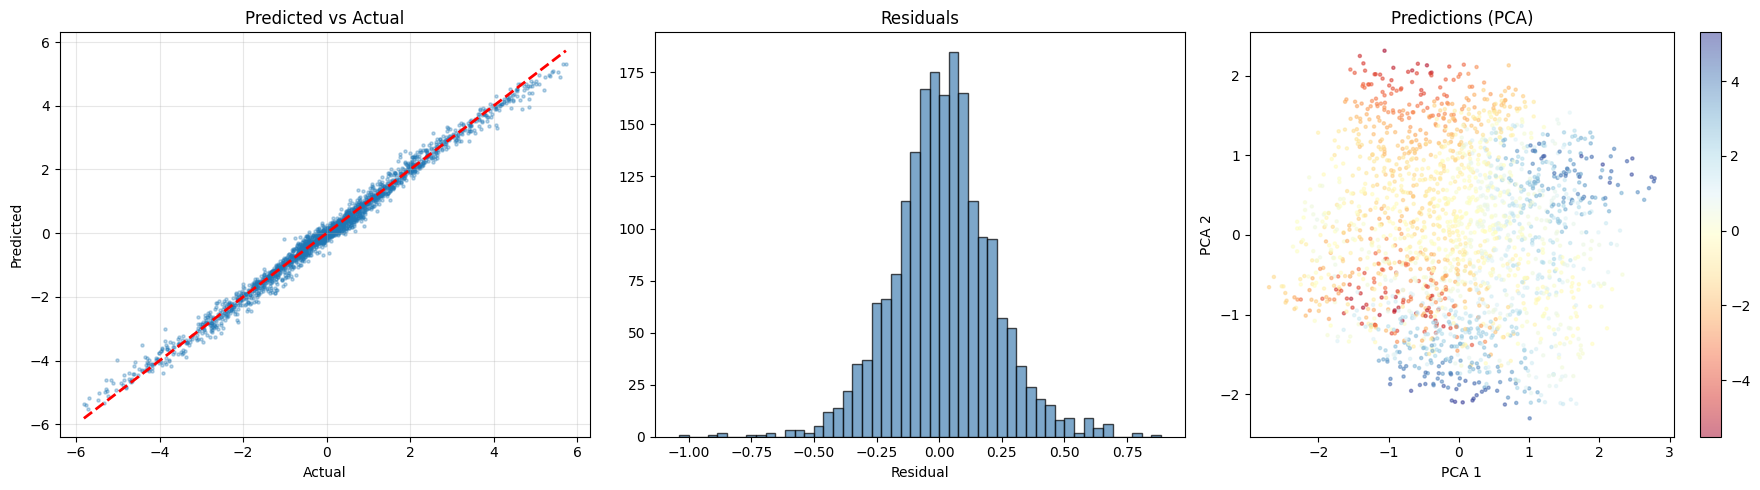

R-squared: 0.9894 | MAE: 0.1535


In [8]:
Y_pred = model(tf.constant(X_norm)).numpy()
Y_pred_d = Y_pred * Y_std + Y_mean
res = Y_np.flatten() - Y_pred_d.flatten()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].scatter(Y_np.flatten(), Y_pred_d.flatten(), alpha=0.3, s=5)
axes[0].plot([Y_np.min(), Y_np.max()], [Y_np.min(), Y_np.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual'); axes[0].set_ylabel('Predicted')
axes[0].set_title('Predicted vs Actual'); axes[0].grid(True, alpha=0.3)

axes[1].hist(res, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Residual'); axes[1].set_title('Residuals')

sc = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=Y_pred_d.flatten(), cmap='RdYlBu', s=5, alpha=0.5)
axes[2].set_xlabel('PCA 1'); axes[2].set_ylabel('PCA 2')
axes[2].set_title('Predictions (PCA)')
plt.colorbar(sc, ax=axes[2])
plt.tight_layout(); plt.show()

r2 = 1 - np.sum(res**2) / np.sum((Y_np.flatten() - Y_np.mean())**2)
print(f'R-squared: {r2:.4f} | MAE: {np.mean(np.abs(res)):.4f}')

## Cell 9: Summary

In [9]:
print('='*60)
print('Colab E(ii): TF Built-in Layers (Subclassing) — Complete!')
print('='*60)
print('Uses: keras.Model subclass, layers.Dense, Adam optimizer')
print('Training: Custom GradientTape loop (NOT model.fit)')
print(f'R-squared: {r2:.4f}')
print('='*60)

Colab E(ii): TF Built-in Layers (Subclassing) — Complete!
Uses: keras.Model subclass, layers.Dense, Adam optimizer
Training: Custom GradientTape loop (NOT model.fit)
R-squared: 0.9894
